# Redes Advers√°rias Generativas (GANs)

Vamos aprender a aplicar as Redes Advers√°rias Generativas (GANs)? Vamos utilizar a cl√°ssica base de dados MNIST. Esse dataset √© disponibilizado pelo Keras e consistem em imagens de treinamento e imagens de teste para classificar d√≠gitos escritos a m√£o que variam entre 0 a 9.

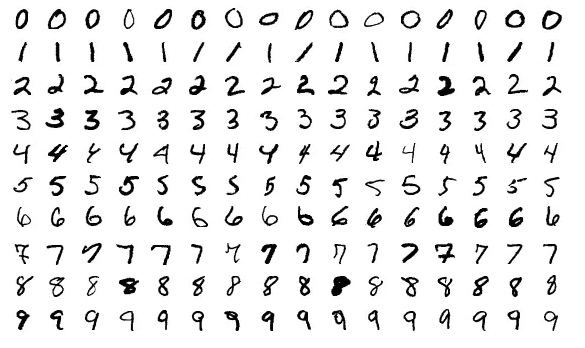

Importando a biblioteca do tensorflow. Tensorflow cont√©m a biblioteca Keras que modela as imagens para redes neurais e tamb√©m a pr√≥pria base de dados que vamos utilizar nessa aula: https://keras.io/api/datasets/mnist/

## O que s√£o as redes advers√°rias gerativas? ü§î

As redes Advers√°rias Generativas possuem um grande potencial pois **s√£o capazes de gerar novos dados a partir de um conjunto de dados treinados**. Podemos treinar essa rede para criar, por exemplo, novas imagens, m√∫sicas, falas, prosas, tratar resolu√ß√µes de imagens e v√≠deos e muito mais. Uma das suas utilidades tamb√©m pode ser criar novas imagens a partir de um conjunto de dados real para criar mais amostras de dados ao treinar uma rede neural convolucional.

Os algoritmos generativos tentam prever os recursos (dados) com um determinado r√≥tulo. Por exemplo, dado que um e-mail √© classificado com spam, qual √© a probabilidade de palavras que formam esse e-mail spam? Os algoritmos discriminativos se preocupam com a correla√ß√£o entre x e y, **modelos generativos se preocupam em ‚Äúcomo voc√™ ir√° obter x‚Äù**.

In [ ]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [ ]:
# Bibliotecas fundamentais para a execu√ß√£o dessa rede
import os
import glob #gerar gif
import imageio #gerar gif
import matplotlib.pyplot as plt # gerar gr√°ficos
import numpy as np # trabalhar com arrays
import PIL # manipular imagens
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
import time

from IPython import display

In [ ]:
# Subindo a base de dados
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # definindo o tamaho da imagem (28x28) com 1 canal de cinza
train_images = (train_images - 127.5) / 127.5 # normalizando a imagem para -1, 1

In [ ]:
BUFFER_SIZE = 60000 # tamanho do conjunto de dados
BATCH_SIZE = 256 # quantidade de pixels que varia

In [ ]:
# criando a base de treinamento
# from_tensor_slices: imagens dentro de um tensor
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) # conjunto de dados + batch para normalizar os pixels

## Criando a rede GANs

Basicamente as GANs s√£o compostas por duas redes, a geradora e a discriminante. S√£o chamadas de advers√°rias porque essas duas redes tentam ‚Äújogar‚Äù uma com a outra o tempo todo. A rede geradora tenta enganar a rede discriminante gerando dados fakes semelhantes aos dados reais.

* O **objetivo da rede discriminate** aqui √© reconhecer que os d√≠gitos gerados a m√£o s√£o o mais pr√≥ximos poss√≠veis dos verdadeiros n√∫meros.

* A **rede geradora** tenta criar novas imagens fakes com a esperan√ßa de torn√°-las aut√™nticas tamb√©m (mesmo sendo falsas).

O funcionamento da rede consiste nas seguintes etapas: O gerador considera n√∫meros aleat√≥rios e retornam uma imagem (ou seja, cria uma imagem fake); Essa imagem fake gerada pelo gerador √© inserida no discriminador ao lado do fluxo de imagens verdadeiras geradas; o discriminador obt√©m imagens reais e falsas retornando a probabilidade realizando previs√µes de imagens falsas geradas pela rede generativa.

Vamos criar como pr√≥ximo passo essas duas redes:

In [ ]:
# criando o nosso modelo gerador de imagens fakes (a partir de uma entrada (ru√≠do) tenta criar uma imagem)

def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # entrada de um ru√≠do randomico (a primeira imagem vai ter a profundidade 256 de 7*7)
  model.add(layers.BatchNormalization()) # t√©cnica que normaliza (z-score) os pesos de uma camada para a pr√≥xima camada # limita os valores em um m√°ximo e um m√≠nimo (ajuda a ficar com um valor est√°vel)
  model.add(layers.LeakyReLU())          # fun√ß√£o de ativa√ß√£o onde os valores negativos sejam transmitidos (atribui um valor pequeno para aproximar o valor √† 0)

  model.add(layers.Reshape((7,7,256))) #para deixar no formato de imagem
  assert model.output_shape == (None, 7, 7, 256) # None √© o batch size

  #Conv2DTranspose: camada de convolu√ß√£o para aumentar a imagem #padding aplicar bordas de zeros para ajudar a aumentar a imagem
  model.add(layers.Conv2DTranspose(128,(5, 5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5, 5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5, 5), strides=(2,2), padding='same', use_bias=False, activation='tanh')) #imagem final da imagem gerada canal 1
  assert model.output_shape == (None, 28, 28, 1)

  return model

Agora utilizando a fun√ß√£o geradora de imagens, vamos ver o que ela pode criar de forma aleat√≥ria.

Criando a primeira imagem nunca treinada antes:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


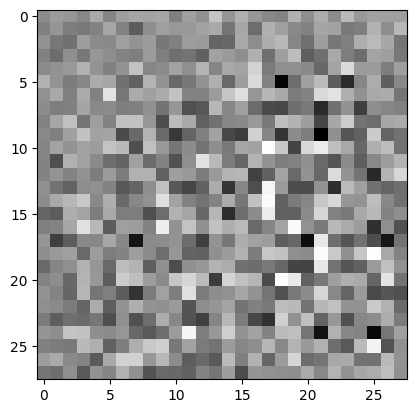

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100]) # ru√≠do
generator_image = generator(noise, training=False) # entrada inicial

plt.imshow(generator_image[0, :, :, 0], cmap='gray')

Agora vamos criar a fun√ß√£o do modelo discriminativo:

In [ ]:
# classifica a imagem entre real e fake
# rede convolucional que discrimina imagem real de imagem fake
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generator_image) # valor positivo, imagem real. Valor negativo, imagem fake.
print(decision)

tf.Tensor([[-0.0003852]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


O discriminador acusou um valor POSITIVO para essa imagem gerada de forma aleat√≥ria. Ou seja, considerou a imagem real.

(No meu exemplo discriminador acusou um valor NEGATIVO, ou seja, considerou uma imagem fake.)

Criar a rede Gans onde a cada √©poca a imagem vai ser constru√≠da. Vamos a princ√≠pio configurar a fun√ß√£o de custo e para essa solu√ß√£o vamos utilizar a Adam.

Relembrando, o Adam combina elementos do m√©todo do momento (momentum) e da m√©dia m√≥vel exponencial para **ajustar as taxas de aprendizado de forma adaptativa** para cada par√¢metro do modelo.

In [ ]:
# configurando a fun√ß√£o de custo (loss function)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) # crio uma fun√ß√£o loss

Cada modelo precisa ter sua **fun√ß√£o de custo** parametrizada:

Para cada sa√≠da do generator, o **discriminator avalia se a imagem √© fake. A id√©ia √© o discriminator atualizar os pesos baseado no erro gerado para o discriminator considerar essa imagem real** (quanto mais pr√≥ximo de 1, mais aceit√°vel ser√° pelo discriminator)

O generator tenta enganar o discriminator. Um depende do outro para para a rede funcionar.

**O generator criar cada vez melhor imagens fakes e o discriminator cada vez mais saber avaliar as imagens se s√£o fakes ou reais**.

In [ ]:
# fun√ß√£o loss para o discriminador

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output) # dado real # 1 verdadeiro
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # dado fake # 0 falso
  total_loss = real_loss + fake_loss # faz a compara√ß√£o
  return total_loss

In [ ]:
# avaliar fake gerado
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output) # dado fake apenas

In [ ]:
# definindo o otimizador da fun√ß√£o de custo Adam
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Vamos criar um checkpoint para salvar o aprendizado do modelo. Voc√™ vai perceber que esses modelos de deep learning costumam demorar muito no aprendizado e processamento. Ter um checkpoint para salvar o aprendizado √© uma boa dica!

In [ ]:
# para salvar o modelo
checkpoint_dir = './training_checkpoints' #diret√≥rio para salvar pontos espec√≠ficos de rede
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

Vamos definir as √©pocas de processamento:

In [ ]:
EPOCHS = 35
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Vamos criar uma fun√ß√£o para acompanharmos a evolu√ß√£o da rede:

In [ ]:
# criando uma fun√ß√£o para mostrar a evolu√ß√£o dos passos de treinamento

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # Gerando ru√≠do aleat√≥rio para a entrada do gerador
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Usando GradientTape para registrar as opera√ß√µes para o c√°lculo do gradiente
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Gerando imagens usando o gerador
        generated_images = generator(noise, training=True)

        # Calculando as sa√≠das reais e falsas usando o discriminador
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculando as perdas do gerador e do discriminador
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculando os gradientes em rela√ß√£o aos par√¢metros do gerador e do discriminador
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Aplicando os gradientes usando otimizadores separados para gerador e discriminador
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Como pr√≥ximo passo, vamos criar a fun√ß√£o respons√°vel por treinar a rede! Nessa fun√ß√£o vamos utilizar o checkpoint para salvar o processamento da rede e vamos utilizar a fun√ß√£o generate_and_save_images (que ser√° criada logo em seguida) para gerar as imagens processadas pela rede.

In [ ]:
def train(dataset, epochs):
  # Itera sobre o n√∫mero especificado de √©pocas
  for epoch in range(epochs):
    start = time.time()  # Marca o in√≠cio do tempo para esta √©poca

    # Itera sobre os lotes de imagens no conjunto de dados
    for image_batch in dataset:
      train_step(image_batch)  # Chama a fun√ß√£o de treinamento definida anteriormente para um lote de imagens

    # Produz imagens para o GIF enquanto treina
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Salva o modelo a cada 15 √©pocas
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    # Imprime o tempo decorrido para a √©poca atual
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Gera e salva imagens ap√≥s a √∫ltima √©poca
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)


In [ ]:
# Fun√ß√£o para gerar e salvar imagens usando o modelo treinado

def generate_and_save_images(model, epoch, test_input):
  # Observa√ß√£o: `training` √© definido como False.
  # Isso √© para que todas as camadas funcionem no modo de infer√™ncia (batchnorm).
  predictions = model(test_input, training=False)  # Modo de treinamento False para o gerador criar as imagens

  # Configura√ß√£o da figura para exibir as imagens geradas
  fig = plt.figure(figsize=(4, 4))

  # Itera sobre as previs√µes geradas
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # Ajusta a escala e exibe a imagem gerada
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')  # Desliga as coordenadas do eixo

  # Salva a imagem gerada
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()  # Exibe a imagem gerada no momento


E vamos treinar essa rede?

Voc√™ vai notar que o tempo de processamento dessa rede neural √© muito longo, a minha aqui deu aproximadamente 2 horas üòØ

Por isso √© importante ter os checkpoints definido!

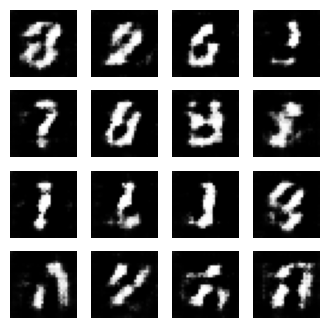

Time for epoch 10 is 772.4996137619019 sec


In [ ]:
train(train_dataset, EPOCHS)